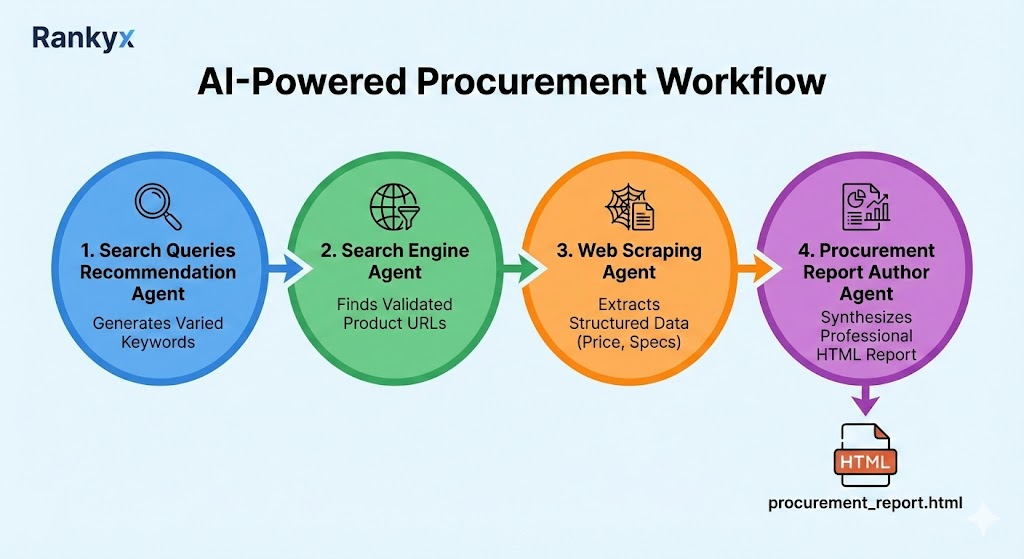

In [ ]:
!pip install -U pip
!pip install crewai
!pip install crewai-tools
!pip install agentops


In [ ]:
!pip install -qU tavily-python scrapegraph-py

In [ ]:
!pip install ollama

In [ ]:
from crewai import Agent, Task, Crew, Process, LLM
from crewai.tools import tool
from crewai.knowledge.source.string_knowledge_source import StringKnowledgeSource
import agentops
from google.colab import userdata
from pydantic import BaseModel, Field
from typing import List
from tavily import TavilyClient
from scrapegraph_py import Client
import ollama
import os
import json

In [ ]:
import ollama
import os
import time

# --- Ollama Server Setup (Run these once per Colab session) ---
# Install Ollama if not already installed
# Note: This checks if ollama binary exists to avoid re-installation on every run
if not os.path.exists('/usr/local/bin/ollama'):
    print("Installing Ollama...")
    !curl -fsSL https://ollama.com/install.sh | sh
    print("Ollama installed.")
else:
    print("Ollama is already installed.")

# Start Ollama server in the background
# Check if Ollama server is already running to avoid multiple instances
server_running = False
try:
    # Attempt a small request to check if server is responsive
    ollama.Client(host='http://127.0.0.1:11434').list()
    server_running = True
except Exception:
    pass

if not server_running:
    print("Starting Ollama server in the background...")
    # Use nohup and & to run in background, redirecting output to /dev/null
    # This prevents the server from blocking the notebook execution
    !nohup ollama serve > /dev/null 2>&1 &
    print("Ollama server started. Waiting for it to become ready...")
    # Give the server a few seconds to start up
    time.sleep(5)
    # Verify it's running
    try:
        ollama.Client(host='http://127.0.0.1:11434').list()
        print("Ollama server is ready.")
    except Exception as e:
        print(f"Failed to start Ollama server: {e}")
        print("Please check the server logs if available or restart the runtime.")
else:
    print("Ollama server is already running.")

# Pull the specific model if not already available
model_name = 'llama3.1:8b'
client_local = ollama.Client(host='http://127.0.0.1:11434')
installed_models = [m['name'] for m in client_local.list()['models']]

if model_name not in installed_models:
    print(f"Pulling model {model_name}. This may take some time...")
    !ollama pull {model_name}
    print(f"Model {model_name} pulled successfully.")
else:
    print(f"Model {model_name} is already pulled.")

# --- Your original code to use the Ollama client ---
# Use the Client class for explicit host
client = ollama.Client(host='http://127.0.0.1:11434')

# Chat with the model
response = client.chat(
    model=model_name,
    messages=[{'role': 'user', 'content': 'Hello! What is the capital of Egypt?'}]
)

# Print the response
print(response['message']['content'])


In [ ]:
!pip install -q langchain langchain-community langchain-ollama crewai

In [ ]:
from langchain_ollama import OllamaLLM

# Configure the LLM to use your local Ollama model
basic_llm = OllamaLLM(
    model="llama3.1:8b",
    base_url="http://127.0.0.1:11434",
    temperature=0
)

In [ ]:
# # please register Agentops account then go to
# # (https://app.agentops.ai/get-started)
# # to get the api key

# os.environ["OPENAI_API_KEY"] = userdata.get('openai-colab')
# os.environ["AGENTOPS_API_KEY"] = userdata.get('agentops-colab')

# agentops.init(
#     api_key=userdata.get('agentops-colab'),
#     skip_auto_end_session=True,
#     default_tags=['crewai']
# )

In [ ]:
print(agentops.get_client().config.exporter_endpoint)

In [ ]:
# output_dir = "./ai-agent-output"
# os.makedirs(output_dir, exist_ok=True)

# basic_llm = LLM(model="gpt-4.1-mini-2025-04-14", temperature=0)
# search_client = TavilyClient(api_key=userdata.get('tvly-search'))
# scrape_client = Client(api_key=userdata.get('scrapegraph'))

In [ ]:
no_keywords = 10

about_company = "Rankyx is a company that provides AI solutions to help websites refine their search and recommendation systems."

company_context = StringKnowledgeSource(
    content=about_company
)

## Setup Agents

### Agent: A

In [ ]:
class SuggestedSearchQueries(BaseModel):
    queries: List[str] = Field(..., title="Suggested search queries to be passed to the search engine",
                               min_items=1, max_items=no_keywords)

search_queries_recommendation_agent = Agent(
    role="Search Queries Recommendation Agent",
    goal="\n".join([
                "To provide a list of suggested search queries to be passed to the search engine.",
                "The queries must be varied and looking for specific items."
            ]),
    backstory="The agent is designed to help in looking for products by providing a list of suggested search queries to be passed to the search engine based on the context provided.",
    llm=basic_llm,
    verbose=True,
)

search_queries_recommendation_task = Task(
    description="\n".join([
        "Rankyx is looking to buy {product_name} at the best prices (value for a price strategy)",
        "The campany target any of these websites to buy from: {websites_list}",
        "The company wants to reach all available proucts on the internet to be compared later in another stage.",
        "The stores must sell the product in {country_name}",
        "Generate at maximum {no_keywords} queries.",
        "The search keywords must be in {language} language.",
        "Search keywords must contains specific brands, types or technologies. Avoid general keywords.",
        "The search query must reach an ecommerce webpage for product, and not a blog or listing page."
    ]),
    expected_output="A JSON object containing a list of suggested search queries.",
    output_json=SuggestedSearchQueries,
    output_file=os.path.join(output_dir, "step_1_suggested_search_queries.json"),
    agent=search_queries_recommendation_agent
)

### Agent: B

In [ ]:
class SignleSearchResult(BaseModel):
    title: str
    url: str = Field(..., title="the page url")
    content: str
    score: float
    search_query: str

class AllSearchResults(BaseModel):
    results: List[SignleSearchResult]

@tool
def search_engine_tool(query: str):
    """Useful for search-based queries. Use this to find current information about any query related pages using a search engine"""
    return search_client.search(query)

search_engine_agent = Agent(
    role="Search Engine Agent",
    goal="To search for products based on the suggested search query",
    backstory="The agent is designed to help in looking for products by searching for products based on the suggested search queries.",
    llm=basic_llm,
    verbose=True,
    tools=[search_engine_tool]
)

search_engine_task = Task(
    description="\n".join([
        "The task is to search for products based on the suggested search queries.",
        "You have to collect results from multiple search queries.",
        "Ignore any susbicious links or not an ecommerce single product website link.",
        "Ignore any search results with confidence score less than ({score_th}) .",
        "The search results will be used to compare prices of products from different websites.",
    ]),
    expected_output="A JSON object containing the search results.",
    output_json=AllSearchResults,
    output_file=os.path.join(output_dir, "step_2_search_results.json"),
    agent=search_engine_agent
)

### Agent: C

In [ ]:
class ProductSpec(BaseModel):
    specification_name: str
    specification_value: str

class SingleExtractedProduct(BaseModel):
    page_url: str = Field(..., title="The original url of the product page")
    product_title: str = Field(..., title="The title of the product")
    product_image_url: str = Field(..., title="The url of the product image")
    product_url: str = Field(..., title="The url of the product")
    product_current_price: float = Field(..., title="The current price of the product")
    product_original_price: float = Field(title="The original price of the product before discount. Set to None if no discount", default=None)
    product_discount_percentage: float = Field(title="The discount percentage of the product. Set to None if no discount", default=None)

    product_specs: List[ProductSpec] = Field(..., title="The specifications of the product. Focus on the most important specs to compare.", min_items=1, max_items=5)

    agent_recommendation_rank: int = Field(..., title="The rank of the product to be considered in the final procurement report. (out of 5, Higher is Better) in the recommendation list ordering from the best to the worst")
    agent_recommendation_notes: List[str]  = Field(..., title="A set of notes why would you recommend or not recommend this product to the company, compared to other products.")


class AllExtractedProducts(BaseModel):
    products: List[SingleExtractedProduct]


@tool
def web_scraping_tool(page_url: str):
    """
    An AI Tool to help an agent to scrape a web page

    Example:
    web_scraping_tool(
        page_url="https://www.noon.com/egypt-en/15-bar-fully-automatic-espresso-machine-1-8-l-1500"
    )
    """
    details = scrape_client.smartscraper(
        website_url=page_url,
        user_prompt="Extract ```json\n" + SingleExtractedProduct.schema_json() + "```\n From the web page"
    )

    return {
        "page_url": page_url,
        "details": details
    }

scraping_agent = Agent(
    role="Web scraping agent",
    goal="To extract details from any website",
    backstory="The agent is designed to help in looking for required values from any website url. These details will be used to decide which best product to buy.",
    llm=basic_llm,
    tools=[web_scraping_tool],
    verbose=True,
)

scraping_task = Task(
    description="\n".join([
        "The task is to extract product details from any ecommerce store page url.",
        "The task has to collect results from multiple pages urls.",
        "Collect the best {top_recommendations_no} products from the search results.",
    ]),
    expected_output="A JSON object containing products details",
    output_json=AllExtractedProducts,
    output_file=os.path.join(output_dir, "step_3_search_results.json"),
    agent=scraping_agent
)

### Agent: D

In [ ]:
procurement_report_author_agent = Agent(
    role="Procurement Report Author Agent",
    goal="To generate a professional HTML page for the procurement report",
    backstory="The agent is designed to assist in generating a professional HTML page for the procurement report after looking into a list of products.",
    llm=basic_llm,
    verbose=True,
)

procurement_report_author_task = Task(
    description="\n".join([
        "The task is to generate a professional HTML page for the procurement report.",
        "You have to use Bootstrap CSS framework for a better UI.",
        "Use the provided context about the company to make a specialized report.",
        "The report will include the search results and prices of products from different websites.",
        "The report should be structured with the following sections:",
        "1. Executive Summary: A brief overview of the procurement process and key findings.",
        "2. Introduction: An introduction to the purpose and scope of the report.",
        "3. Methodology: A description of the methods used to gather and compare prices.",
        "4. Findings: Detailed comparison of prices from different websites, including tables and charts.",
        "5. Analysis: An analysis of the findings, highlighting any significant trends or observations.",
        "6. Recommendations: Suggestions for procurement based on the analysis.",
        "7. Conclusion: A summary of the report and final thoughts.",
        "8. Appendices: Any additional information, such as raw data or supplementary materials.",
    ]),

    expected_output="A professional HTML page for the procurement report.",
    output_file=os.path.join(output_dir, "step_4_procurement_report.html"),
    agent=procurement_report_author_agent,
)

## Run the AI Crew

In [ ]:
rankyx_crew = Crew(
    agents=[
        search_queries_recommendation_agent,
        search_engine_agent,
        scraping_agent,
        procurement_report_author_agent,
    ],
    tasks=[
        search_queries_recommendation_task,
        search_engine_task,
        scraping_task,
        procurement_report_author_task,
    ],
    process=Process.sequential,
    knowledge_sources=[company_context]

)

In [ ]:
crew_results = rankyx_crew.kickoff(
    inputs={
        "product_name": "coffee machine for the office",
        "websites_list": ["www.amazon.eg", "www.jumia.com.eg", "www.noon.com/egypt-en"],
        "country_name": "Egypt",
        "no_keywords": 5,
        "language": "English",
        "score_th": 0.10,
        "top_recommendations_no": 5
    }
)